# Chapter 9

## Example of Monte Carlo Methods

In [1]:
import numpy as np
 
np.random.seed(42)
DAYS = 30
P_ATTACK = 0.05
P_FOOD = 0.3
FOOD_DURATION = 3
MAX_DAYS_NO_FOOD = 5
SIMULATIONS = 1_000_000
 
def simulate_survival():
    food_left = 0
    no_food_streak = 0
 
    for _ in range(DAYS):
        if np.random.rand() < P_ATTACK:
            # KILLED BY AN ANIMAL
            return False
 
        if np.random.rand() < P_FOOD:
            food_left += FOOD_DURATION
            no_food_streak = 0
        else:
            if food_left > 0:
                food_left -= 1
            else:
                no_food_streak += 1
                if no_food_streak >= MAX_DAYS_NO_FOOD:
                    # STARVED TO DEATH
                    return False
                
    # SURVIVED
    return True 
 
survival_probability = np.mean(
    [simulate_survival()
     for _ in range(SIMULATIONS)]
    ) 
print(f"Survival probability: {survival_probability:.2%}")

Survival probability: 15.19%


## Implementation

Takes +20 minutes to execute

In [2]:
import yfinance as yf
from chapter_9 import Montecarlo

ticker = 'NVDA'
START_DATE = '2020-01-01'
END_DATE = '2024-12-31'
 
asset_prices = yf.Ticker(ticker).history(
    start=START_DATE,
    end=END_DATE,
    interval='1d'
)
 
montecarlo = Montecarlo(
    asset_prices=asset_prices,
    exposure_pct=0.72,
    num_iterations=500,
    max_exposure_error=0.025
)
results = montecarlo.run()


100%|██████████| 1257/1257 [00:02<00:00, 476.00it/s]


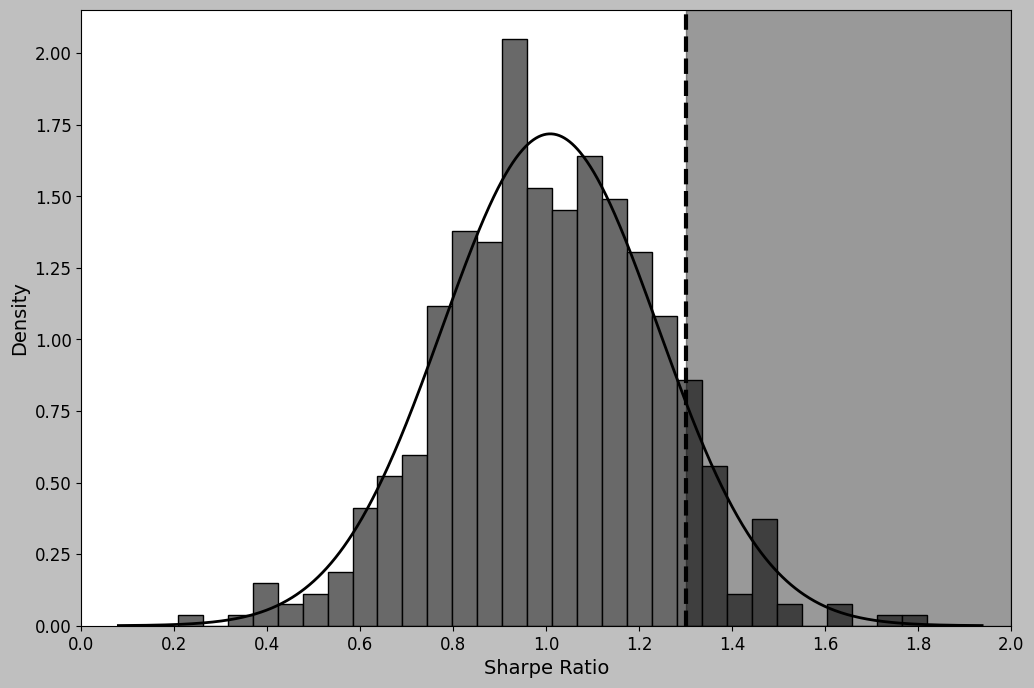

In [10]:
import matplotlib.pyplot as plt


plt.style.use('grayscale')
plt.figure(figsize=(12, 8))

sharpes = [result['sharpe_ratio'] for result in results]
mean, std = np.mean(sharpes), np.std(sharpes)

plt.hist(
    [result['sharpe_ratio'] for result in results],
    bins=30,
    color='dimgrey',
    edgecolor='black',
    density=True,
)

plt.xticks(np.arange(-4, 5, 0.2), fontsize=12)
x = np.linspace(mean - 4 * std, mean + 4 * std, 1000)
y = (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std) ** 2)
plt.plot(x, y, color='black', linewidth=2)
plt.xlabel('Sharpe Ratio', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.yticks(fontsize=12)
plt.axvline(1.3, color='black', linestyle='--', linewidth=3)
plt.axvspan(1.3, 2, color='black', alpha=0.4)
plt.xlim(0, 2)
plt.show()

In [4]:
from scipy import stats
 
def get_p_value(
    metric_value, 
    montecarlo_results, 
    target_variable='sharpe_ratio'):
    
    # PARAMETRIC CALCULATION
    variable_results = [
        item[target_variable] 
        for item in montecarlo_results
        ]
    mu = np.mean(variable_results)
    sigma = np.std(variable_results)
    z_score = (metric_value - mu) / sigma
    p_val_param = 1 - stats.norm.cdf(z_score)
    
    # EMPIRICAL CALCULATION
    p_val_non_param = (
        sum(
        x > metric_value 
        for x in variable_results) 
        / len(variable_results)
        )
 
    return {
        'p_value_parametric': p_val_param,
        'p_value_non_parametric': p_val_non_param,
        'mu': mu,
        'sigma': sigma,
        'z_score': z_score,
    }
 


In [12]:
get_p_value(
    metric_value=1.3,
    montecarlo_results=results,
    target_variable='sharpe_ratio'
)

{'p_value_parametric': 0.10469447173774937,
 'p_value_non_parametric': 0.092,
 'mu': 1.0085459763188216,
 'sigma': 0.23218850002740699,
 'z_score': 1.2552474547480856}